**First Section will be random closures of roads, meaning random removal of edges until the network becomes two componenents**

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import random

In [45]:
df = pd.read_csv("GoldCoast_network.csv")
df_simple_net = df[["From","To","Length"]]
df_simple_net

G = nx.from_pandas_edgelist(df_simple_net,source = "From", target="To", edge_attr="Length", create_using=nx.DiGraph())
Nodes = G.number_of_nodes()
Edges = G.number_of_edges()
Nodes, Edges
df

,From,To,Capacity,Length,FreeFlowTime,B,Power,SpeedLimit,CriticalSpeed,Lanes
0,1,1371,900.0,0.30,0.327,0.282,4.0,55,42.9,2
1,2,2012,1600.0,0.26,0.173,0.282,4.0,90,70.2,2
2,3,2402,1100.0,0.20,0.200,0.282,4.0,60,46.8,2
3,4,1875,800.0,0.16,0.128,0.282,4.0,75,58.5,1
4,5,1880,800.0,0.20,0.171,0.282,4.0,70,54.6,1
...,...,...,...,...,...,...,...,...,...,...
11135,4806,1495,600.0,0.09,0.120,0.667,4.0,45,27.0,1
11136,4806,3606,600.0,0.09,0.120,0.667,4.0,45,27.0,1
11137,4806,415,1800.0,0.23,0.575,0.000,4.0,24,24.0,5
11138,4807,1433,400.0,0.05,0.060,0.667,4.0,50,30.0,2


**Fine approach, but easily broken by the fact many nodes have degree 1.**

In [40]:
def random_closure(graph):
    edgelist = list(graph.edges())
    np.random.seed(42)
    iter = 0
    edge_removed_list = []
  
    while nx.number_weakly_connected_components(graph) < 4:
        edge = edgelist[np.random.randint(len(edgelist))]
        edge_removed_list.append(edge)
        graph.remove_edge(*edge)
        edgelist.remove(edge)
        #print(f"{edge} removed")
        iter += 1
    return iter, edge_removed_list, list(nx.weakly_connected_components(graph))
    

In [41]:
def random_closure_thresh(graph, threshold = 0.5):
    G = graph.copy()
    edgelist =list(G.edges())
    N = G.number_of_nodes()
    edge_removed_list = []
    iter = 0

    current_gc_size = N

    while current_gc_size >= threshold*N:
        edge_index = np.random.randint(len(edgelist))
        edge = edgelist.pop(edge_index)
        G.remove_edge(*edge)
        edge_removed_list.append(edge)
        iter += 1

        components = list(nx.weakly_connected_components(G))
        current_gc_size = max(len(c) for c in components)

    return iter, edge_removed_list, G


In [8]:
for i in range(10):
    iter, removed_edges,graph = random_closure_thresh(G)
    print(f"ran {i} times: ",iter)

ran 0 times:  3861
ran 1 times:  4212
ran 2 times:  3960
ran 3 times:  4626
ran 4 times:  3922
ran 5 times:  3705
ran 6 times:  3983
ran 7 times:  3986
ran 8 times:  4392
ran 9 times:  4248


In [47]:
G_copy = G.copy()

In [48]:
iters, removed_edges, graph = random_closure_thresh(G_copy)



In [49]:
components = list(nx.weakly_connected_components(graph))

In [50]:
color_map = {}
for i, comp in enumerate(components):
    for node in comp:
        color_map[node] = i

In [51]:
nodes = pd.read_csv("nodes.csv")
edges = df_simple_net
pos = {row.node: (row.x, row.y) for _, row in nodes.iterrows()}

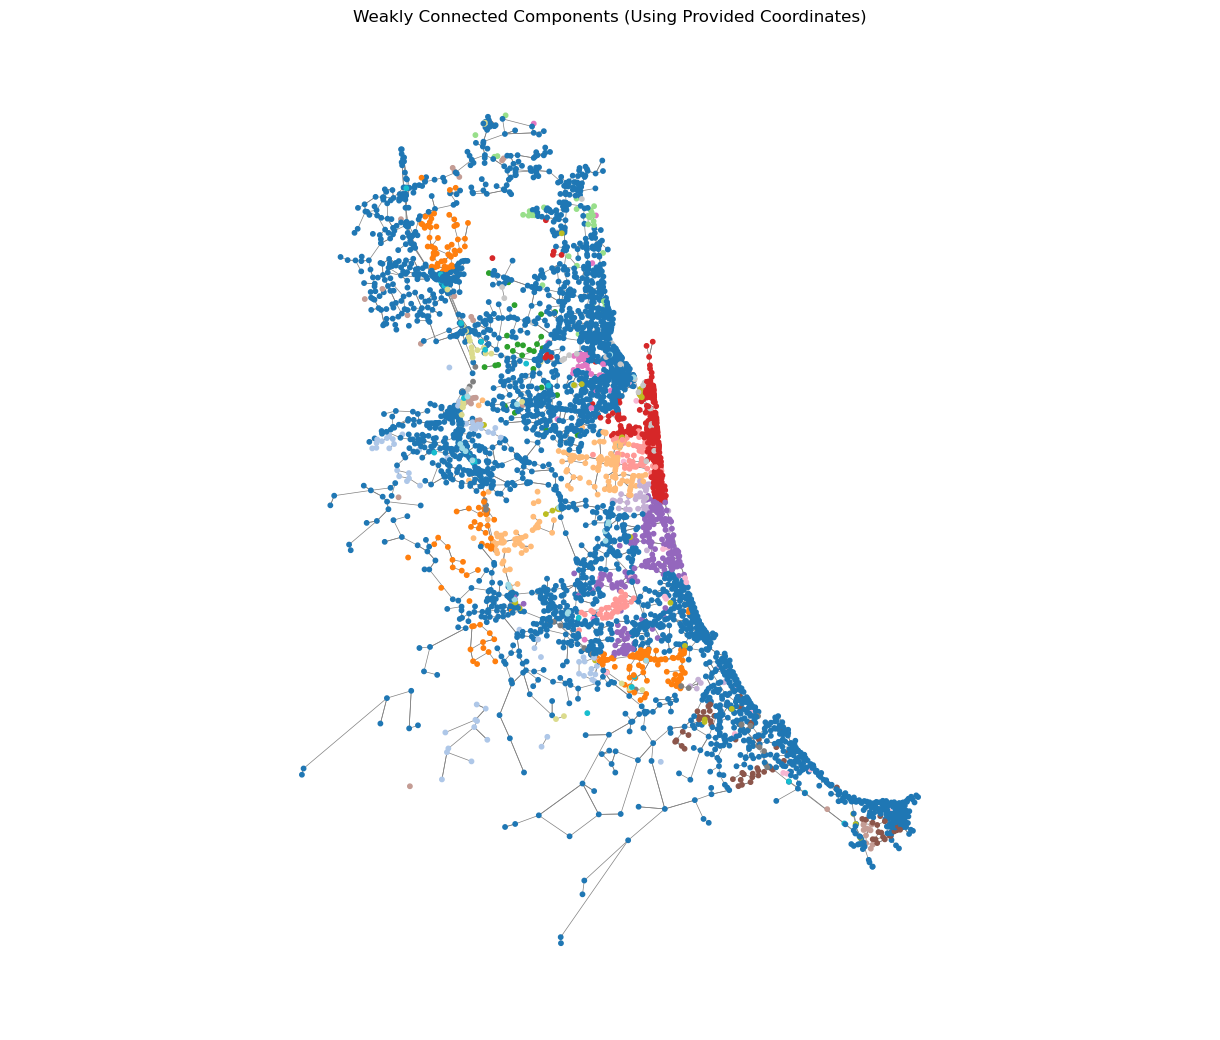

In [52]:
node_colors = [color_map[n] for n in graph.nodes()]

# plot
plt.figure(figsize=(12, 10))

nx.draw(
    graph,
    pos=pos,                      # ← your spatial layout
    node_color=node_colors,       # colors by component
    cmap=plt.cm.tab20,            # many distinct colors
    node_size=10,
    edge_color="gray",
    width=0.5,
    arrows = False,
    with_labels=False             # turn on if needed
)

plt.title("Weakly Connected Components (Using Provided Coordinates)")
plt.axis("equal")
plt.show()

In [53]:
def random_closure_track(graph, threshold=0.5):
    G = graph.copy()
    edgelist = list(G.edges())
    N = G.number_of_nodes()
    
    edge_removed_list = []
    gc_history = []      # <-- record giant component size
    iter = 0

    components = list(nx.weakly_connected_components(G))
    current_gc_size = max(len(c) for c in components)
    gc_history.append(current_gc_size / N)   # record initial ratio

    while current_gc_size >= threshold * N:
        edge_index = np.random.randint(len(edgelist))
        edge = edgelist.pop(edge_index)
        G.remove_edge(*edge)
        edge_removed_list.append(edge)
        iter += 1
        
        components = list(nx.weakly_connected_components(G))
        current_gc_size = max(len(c) for c in components)
        
        gc_history.append(current_gc_size / N)   # record updated ratio

    return iter, edge_removed_list, G, gc_history

iters, removed_edges, graph, gc_hist = random_closure_track(G_copy)

In [15]:
iters

4449

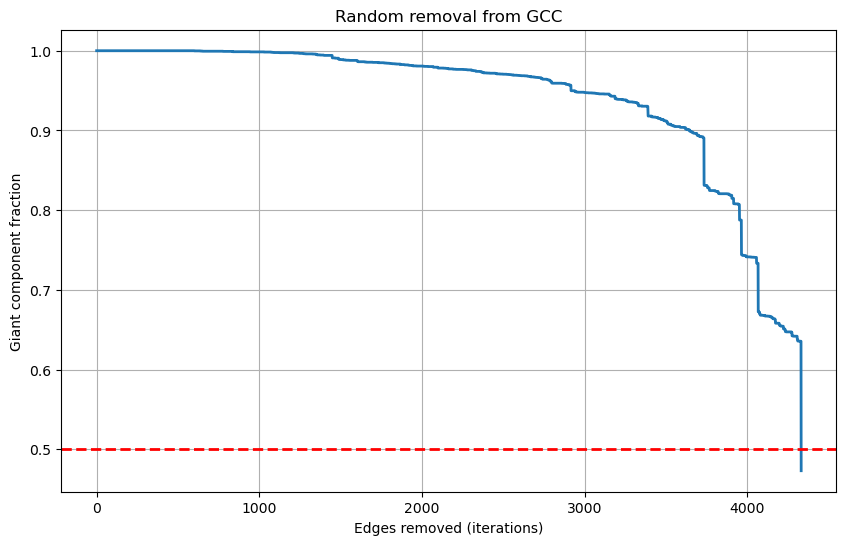

In [54]:
plt.figure(figsize=(10,6))
plt.plot(gc_hist, linewidth=2)
plt.axhline(0.5, linestyle="--", linewidth=2, color="Red")   # threshold line

plt.xlabel("Edges removed (iterations)")
plt.ylabel("Giant component fraction")
plt.title("Random removal from GCC")
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=20,
    linewidths=0,
    arrows=False,
    edge_color="gray",
    alpha=0.7,
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=removed_edges,
    edge_color="red",
    style="-",
    arrows=False,
    width=2.5,        # thicker line to highlight
    alpha=0.9
)

plt.title("Network Graph (Node Coordinates)")
plt.show()

TA CODE

In [23]:
import networkx as nx
import itertools
from multiprocessing import Pool
import math # Added for a potentially cleaner way to calculate chunk size

def chunks(l, n):
    l_c = iter(l)
    while True:
        x = tuple(itertools.islice(l_c, n))
        
        # Corrected indentation and logic: check if the slice is empty
        if not x:
            return 
        
        yield x

def betweenness_centrality_parallel_edge(G, processes=None):
    # 1. Initialize the Pool
    p = Pool(processes=processes)
    
    # Use the actual number of processes available in the Pool
    num_processes = len(p._pool) 
    
    # 2. Divide nodes into chunks
    chunk_size = math.ceil(G.order() / num_processes) 
    node_chunks = list(chunks(G.nodes(), chunk_size))
    num_chunks = len(node_chunks)

    # 3. Parallel calculation
    # Uses nx.edge_betweenness_centrality_subset to calculate partial edge centrality
    bt_sc = p.starmap(
        nx.edge_betweenness_centrality_subset,
        zip(
            [G] * num_chunks,        # G: The graph
            node_chunks,             # sources: The chunk of nodes
            [list(G)] * num_chunks,  # targets: All nodes
            [True] * num_chunks,     # normalized: True
            ["Length"] * num_chunks, # weight: The edge attribute to use for shortest paths
        ),
    )
    
    # 4. Terminate the Pool
    p.close()
    p.join()

    #
    # Start with the first result
    bt_e = bt_sc[0]
    
    # Sum the remaining results
    for bt in bt_sc[1:]:
        for edge, centrality in bt.items():
            # Since edges in a directed graph are unique (u, v) != (v, u), 
            # we just sum the centralities for the edge tuple.
            bt_e[edge] += centrality
            
    return bt_e

In [20]:
G_copy = G.copy()
node_betweenness = betweenness_centrality_parallel_edge(G_copy, processes=4)

In [24]:
def strategic_closure_betweenness_efficient_parallel(graph, threshold=0.5, processes = None):
    G = graph.copy()
    N = G.number_of_nodes()

    gc_hist = []
    iterations = 0

    # initial GC size
    components = list(nx.weakly_connected_components(G))
    current_gc = max(len(c) for c in components)
    gc_hist.append(current_gc / N)

    while current_gc >= threshold * N:
        # Approximate betweenness: samples k nodes
        bw = betweenness_centrality_parallel_edge(G, processes=processes)

        edge_to_remove = max(bw, key=bw.get)
        G.remove_edge(*edge_to_remove)
        iterations += 1

        components = list(nx.weakly_connected_components(G))
        current_gc = max(len(c) for c in components)
        gc_hist.append(current_gc / N)

    return iterations, G, gc_hist

In [27]:
G_copy = G.copy()
iter, G_re, gc_hist = strategic_closure_betweenness_efficient_parallel(G_copy, processes=4)

In [32]:
iter

2426

In [29]:
node_betweenness[1]

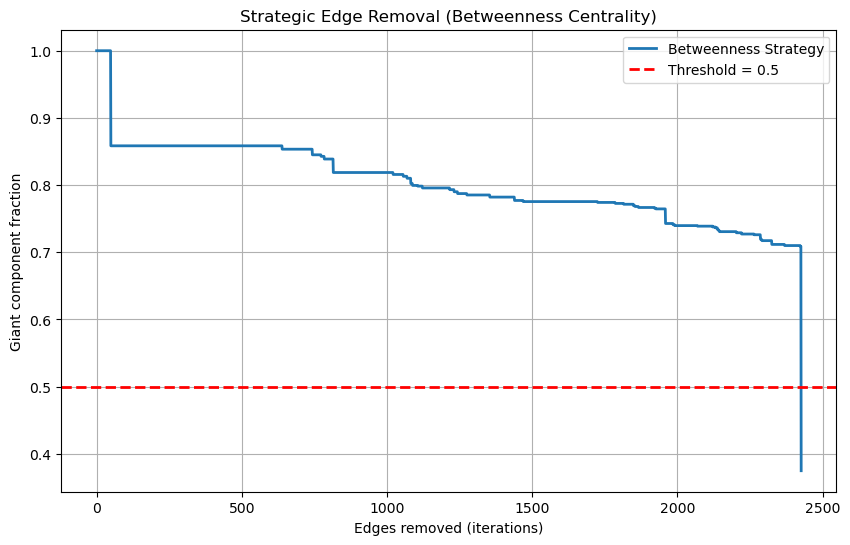

In [33]:
""" 
Visualize the GC size over the number of removals.

"""
plt.figure(figsize=(10, 6))

plt.plot(gc_hist, linewidth=2, label="Betweenness Strategy")
plt.axhline(0.5, linestyle="--", linewidth=2, label="Threshold = 0.5", color="Red")

plt.xlabel("Edges removed (iterations)")
plt.ylabel("Giant component fraction")
plt.title("Strategic Edge Removal (Betweenness Centrality)")
plt.grid(True)
plt.legend()
plt.show()
